In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import xgboost as xgb

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Create train dataframe
train = pd.read_csv('train.csv')

In [3]:
### Create overall features without Id and targets
train['target'] = np.log1p(train["SalePrice"])
features = [c for c in train.columns if c not in['Id','SalePrice', 'target']]

In [4]:
### Create lists containing the numerical and categorical columns
cats = []
nums = []
for c, dtype in zip(train[features].columns, train[features].dtypes):
    if dtype == 'object':
        cats.append(c)
    else:
        nums.append(c)

In [5]:
### Impute means for all nulls in numerical features
from sklearn.preprocessing import Imputer
imputer = Imputer()
imputer = imputer.fit(train[nums])
train[nums] = imputer.transform(train[nums])

In [6]:
### Calculate skewness of numerical features and transforms
from scipy.stats import skew
skewed_feats = train[nums].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
train[skewed_feats] = np.log1p(train[skewed_feats])

In [7]:
### Scale numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train[nums] = scaler.fit_transform(train[nums])

In [8]:
### Add dummy variables for categories
train = pd.get_dummies(train, columns = cats)

In [9]:
### Recreate overall features without Id and targets
features = [c for c in train.columns if c not in['Id','SalePrice', 'target']]

In [10]:
### Select ten top features (should be the same top ten from the correlation above)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
selector = SelectKBest(f_regression, k=10).fit(train[features], train['target'])
feat_scores = [(a,t) for a, t, z in zip(features, selector.scores_, selector.get_support()) if z] 
for i in  feat_scores: print i[0], i[1]

OverallQual 2930.79939346
YearBuilt 764.779834949
YearRemodAdd 685.840721007
1stFlrSF 859.324879374
GrLivArea 1665.86552002
FullBath 798.100327964
GarageCars 1258.34949271
GarageArea 1071.73379994
ExterQual_TA 802.728716845
KitchenQual_TA 594.652569296


In [11]:
### Take the features selected by SelectKBest
top_ten_features = [a for a, t in zip(features, selector.get_support()) if t]

In [12]:
### Root Mean Squared Log Error function for GridSearch
from sklearn.metrics import make_scorer
def rmsle(predicted, actual):
    assert(len(predicted) == len(actual))
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    return (((p - a)**2).sum() / len(predicted))**0.5
rmsle_loss = make_scorer(rmsle, greater_is_better=False)

In [13]:
### Split into train and test
X_train, X_test, y_train, y_test = train_test_split(train[top_ten_features], train['target'], test_size=0.30, random_state=42)

In [14]:
%%time
### GridSearch for number of estimators
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor()
n_estimators = [50, 100, 200, 300]
tuned_parameters = dict(n_estimators=n_estimators)
grid = GridSearchCV(boost, tuned_parameters, cv=3, scoring=rmsle_loss, n_jobs=-1, verbose=2)
grid.fit(train[top_ten_features], train['target'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=100 ................................................
[CV] .................................. n_estimators=50, total=   0.1s
[CV] .................................. n_estimators=50, total=   0.1s
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[CV] .................................. n_estimators=50, total=   0.1s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=100, total=   0.1s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=100, total=   0.1s
[CV] ............

[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.2s remaining:    0.3s


[CV] ................................. n_estimators=300, total=   0.1s
[CV] n_estimators=300 ................................................
[CV] ................................. n_estimators=300, total=   0.1s
[CV] n_estimators=300 ................................................
[CV] ................................. n_estimators=300, total=   0.1s
CPU times: user 202 ms, sys: 48.8 ms, total: 251 ms
Wall time: 980 ms


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.8s finished


In [15]:
### summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.012280 using {'n_estimators': 100}
-0.013295 (0.000393) with: {'n_estimators': 50}
-0.012280 (0.000510) with: {'n_estimators': 100}
-0.012373 (0.000550) with: {'n_estimators': 200}
-0.012552 (0.000505) with: {'n_estimators': 300}


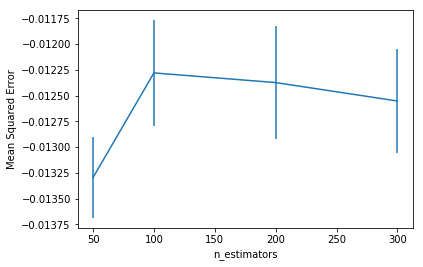

In [16]:
### plot results
plt.errorbar(n_estimators, means, yerr=stds)
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.show()

In [17]:
%%time
### GridSearch for max depth
boost = xgb.XGBRegressor(n_estimators=100)
max_depth = [3,4,5,6,7,8,9,10]
tuned_parameters = dict(max_depth=max_depth)
grid = GridSearchCV(boost, tuned_parameters, cv=3, scoring=rmsle_loss, n_jobs=-1, verbose=2)
grid.fit(train[top_ten_features], train['target'])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=3 .....................................................
[CV] max_depth=3 .....................................................
[CV] max_depth=3 .....................................................
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=3, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=3, total=   0.1s
[CV] ...................................... max_depth=3, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=5 

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.4s finished


In [18]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.012280 using {'max_depth': 3}
-0.012280 (0.000510) with: {'max_depth': 3}
-0.012440 (0.000389) with: {'max_depth': 4}
-0.012508 (0.000366) with: {'max_depth': 5}
-0.012632 (0.000319) with: {'max_depth': 6}
-0.012729 (0.000330) with: {'max_depth': 7}
-0.012591 (0.000263) with: {'max_depth': 8}
-0.012689 (0.000413) with: {'max_depth': 9}
-0.012813 (0.000324) with: {'max_depth': 10}


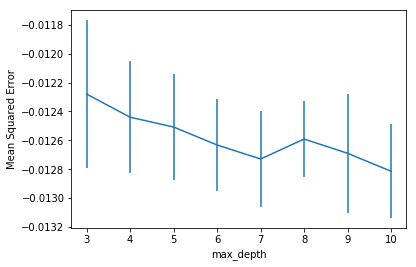

In [19]:
plt.errorbar(max_depth, means, yerr=stds)
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
plt.show()

In [20]:
%%time
### GridSearch for learning rate
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor(n_estimators=100, max_depth=3)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
tuned_parameters = dict(learning_rate=learning_rate)
grid = GridSearchCV(boost, tuned_parameters, cv=3, scoring=rmsle_loss, n_jobs=-1, verbose=2)
grid.fit(train[top_ten_features], train['target'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] learning_rate=0.0001 ............................................
[CV] learning_rate=0.0001 ............................................
[CV] learning_rate=0.0001 ............................................
[CV] learning_rate=0.001 .............................................
[CV] ............................. learning_rate=0.0001, total=   0.0s
[CV] learning_rate=0.001 .............................................
[CV] ............................. learning_rate=0.0001, total=   0.0s
[CV] learning_rate=0.001 .............................................
[CV] ............................. learning_rate=0.0001, total=   0.0s
[CV] .............................. learning_rate=0.001, total=   0.0s
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] .............................. learning_rate=0.001, total=   0.1s
[CV] learning_rat

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.6s finished


In [21]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.012280 using {'learning_rate': 0.1}
-2.087494 (0.000741) with: {'learning_rate': 0.0001}
-1.612606 (0.000885) with: {'learning_rate': 0.001}
-0.392398 (0.000805) with: {'learning_rate': 0.01}
-0.012280 (0.000510) with: {'learning_rate': 0.1}
-0.012529 (0.000527) with: {'learning_rate': 0.2}
-0.012867 (0.000467) with: {'learning_rate': 0.3}


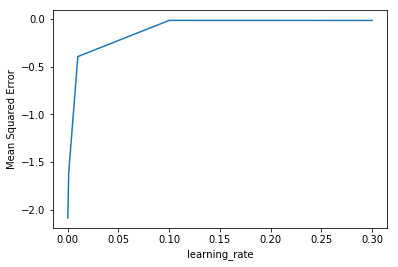

In [22]:
plt.errorbar(learning_rate, means, yerr=stds)
plt.legend()
plt.xlabel('learning_rate')
plt.ylabel('Mean Squared Error')
plt.show()

In [23]:
%%time
### Create dmatrix for xgboost
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

CPU times: user 3.87 ms, sys: 841 µs, total: 4.71 ms
Wall time: 3.83 ms


In [24]:
%%time
### Train until model hasn't improved for 100 rounds
params = {}
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['max_depth'] = 3
params['learning_rate'] = 0.1

watchlist = [(d_train, 'train'), (d_test, 'test')]
boost = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-rmse:10.3846	test-rmse:10.3692
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
[10]	train-rmse:3.63814	test-rmse:3.63439
[20]	train-rmse:1.28735	test-rmse:1.29343
[30]	train-rmse:0.474759	test-rmse:0.486061
[40]	train-rmse:0.213211	test-rmse:0.229174
[50]	train-rmse:0.146806	test-rmse:0.168958
[60]	train-rmse:0.133195	test-rmse:0.159126
[70]	train-rmse:0.128073	test-rmse:0.157431
[80]	train-rmse:0.124754	test-rmse:0.157273
[90]	train-rmse:0.121882	test-rmse:0.157443
[100]	train-rmse:0.119403	test-rmse:0.157608
[110]	train-rmse:0.117011	test-rmse:0.15806
[120]	train-rmse:0.114539	test-rmse:0.158423
[130]	train-rmse:0.112652	test-rmse:0.158294
[140]	train-rmse:0.110702	test-rmse:0.158334
[150]	train-rmse:0.108937	test-rmse:0.158873
[160]	train-rmse:0.107233	test-rmse:0.158904
[170]	train-rmse:0.105352	test-rmse:0.159409
Stopping. Best iteration:
[76]	train-rmse:0.125894	test-rmse:0.1

In [27]:
%%time
### Prepare test data for predictions
test = pd.read_csv('test.csv')
test[nums] = imputer.transform(test[nums])
test[skewed_feats] = np.log1p(test[skewed_feats])
test[nums] = scaler.fit_transform(test[nums])
test = pd.get_dummies(test, columns = cats)
d_test = xgb.DMatrix(test[top_ten_features])

CPU times: user 100 ms, sys: 7.08 ms, total: 107 ms
Wall time: 111 ms


In [28]:
### Make prediction and convert prediction from log
preds = np.expm1(boost.predict(d_test))

In [29]:
### Create submission file
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = preds
submission.to_csv('submission_xgb.csv', index=False)